## Stochastic processes

A stochastic process $X(t)$ is a variable whose value changes over time in an uncertain manner. A stock at time $t$ in a known (observered) interval $t ∈ [t_0, T]$ is defined by a stochastic process

$$
X(t, \omega)
$$

of two variables, meaning that the stock price can be interpreted as a realization at some time $t$ and probabilistic space $\omega$ (path) within an ensemble of realizations $\omega \in \Omega$:

![](./img/sde-example.png)

---

### Implementation and comparison of ABM, GBM and OU processes

There are three fundamental stochastic processes:

| Stochastic process               |                              Equation                             |
|----------------------------------|:-----------------------------------------------------------------:|
| Arithmetic Brownian Motion (ABM) |            $$dS(t) = \mu \cdot dt + \sigma \cdot dW(t)$$            |
| Geometric Brownian Motion (GBM)  | $$dS(t) = \mu \cdot S(t) \cdot dt + \sigma \cdot S(t) \cdot dW(t)$$ |
| Ornstein-Uhlenbeck (OU)          |   $$dS(t) = \kappa (\theta - X(t)) \cdot dt + \sigma \cdot dW(t)$$  |

All of which are based on the Wiener process $W(t)$. In the implementation of the stochastic processes, the most important property of the Winer process

\begin{equation}
	W(t + \Delta t) - W(t) =
	dW(t) = \varepsilon(t) \cdot \sqrt{\Delta t},
\end{equation}

such that the change in the Wiener process is defined by a random component $\varepsilon(t)$ and is dependent on the size of the time step $\Delta t$, allowing to write

\begin{equation}
	dW(t) \sim \mathcal{N}(0, \Delta t).
\end{equation}

Using the [`pyfin.sde` module][pyfin-sde], the methods [`abm()`], [`gbm()`], and [`ou()`] are used to demonstrate the different stochastic processes. These are all sampled with a predefined seed for reproducability.

[pyfin-sde]: https://github.com/martinandrovich/pyfin/blob/main/pyfin/sde.py
[`abm()`]: https://github.com/martinandrovich/pyfin/blob/main/pyfin/sde.py#L7-L44
[`gbm()`]: https://github.com/martinandrovich/pyfin/blob/main/pyfin/sde.py#L47-L86
[`ou()`]:  https://github.com/martinandrovich/pyfin/blob/main/pyfin/sde.py#L89-L120

In [1]:
%run ./config/setup.py

In [2]:
from pyfin.sde import abm, gbm, ou

# parameters

s0 = 1
mu = 0.05
sigma = 0.05
T = 100
dt = 0.01
num_paths = 26

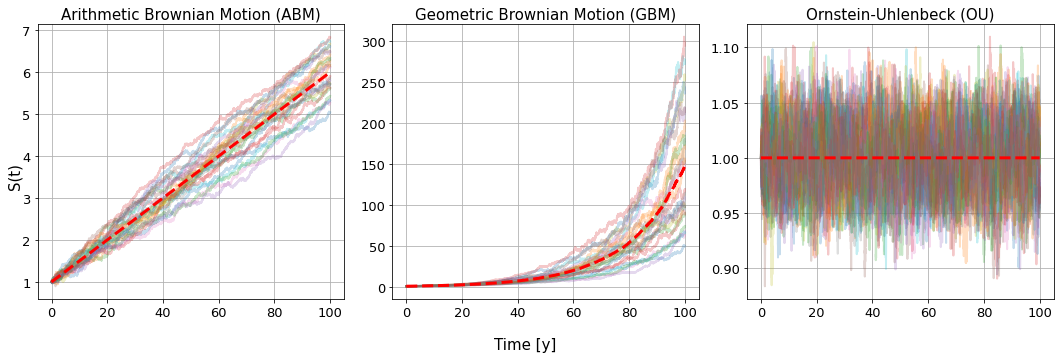

In [3]:
# plot

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

t, S = abm(s0=s0, mu=mu, sigma=sigma, T=T, dt=dt, num_paths=num_paths, reproducible=True)
axs[0].plot(t, S.T, alpha=0.25)
axs[0].plot(t, np.mean(S, axis=0), "r--", linewidth=3)
axs[0].set_title("Arithmetic Brownian Motion (ABM)")

t, S, X = gbm(s0=s0, mu=mu, sigma=sigma, T=T, dt=dt, num_paths=num_paths, reproducible=True)
axs[1].plot(t, S.T, alpha=0.25)
axs[1].plot(t, np.mean(S, axis=0), "r--", linewidth=3)
axs[1].set_title("Geometric Brownian Motion (GBM)")

t, S = ou(s0=s0, kappa=1.5, theta=1.0, sigma=sigma, T=T, dt=dt, num_paths=num_paths, reproducible=True)
axs[2].plot(t, S.T, alpha=0.25)
axs[2].plot(t, np.mean(S, axis=0), "r--", linewidth=3)
axs[2].set_title("Ornstein-Uhlenbeck (OU)")

for ax in axs.flat:
	ax.ticklabel_format(useOffset=False, style="plain")
	ax.grid()
fig.supylabel("S(t)"); fig.supxlabel("Time [y]");

---

### GBM calibration using MLE

Given $m$ number of samples with timestep $\Delta t$ from Tesla (`TSLA`) stock, a maximum-likelohood estimator (MLE) is used to estimate the parameters $\hat{\mu}$ and $\hat{\sigma}$ of a stock $S(t)$ under log transform, as

\begin{equation}
	X(t) = \log(S(t)),
\end{equation}

for which the estimators are given by

\begin{equation}
	\hat{\mu} = \frac{1}{m \Delta t} \cdot (X(t_{m}) - X(t_{0}))
	\quad , \quad
	\hat{\sigma}^{2} = \frac{1}{m \Delta t} \cdot \sum_{k=0}^{m-1} (X(t_{k+1}) - X(t_{k}) - \hat{\mu} \Delta t)^{2}.
\end{equation}

The data set contains closing prices between 2010 and 2018.

In [4]:

import pyfin.datasets

# data

t, S, dt = pyfin.datasets.TSLA()
X = np.log(S)
m = len(t)

# maximum-likelihood estimation
# based on (2.36)

mu = 1/(m * dt) * (X[-1] - X[0])
s = 1/(m * dt) * np.sum([(X[i + 1] - X[i] - mu * dt) ** 2 for i in range(m - 1)])
sigma = sqrt(s)

print(f"MLE calibration yields μ = {mu:.4f} and σ = {sigma:.4f}.")

# simulate ABM

t_est, X_sim = abm(s0=log(S[-1]), mu=mu, sigma=sigma, T=365, dt=1, num_paths=10, reproducible=True)
S_sim = np.exp(X_sim)

MLE calibration yields μ = 0.0014 and σ = 0.0318.


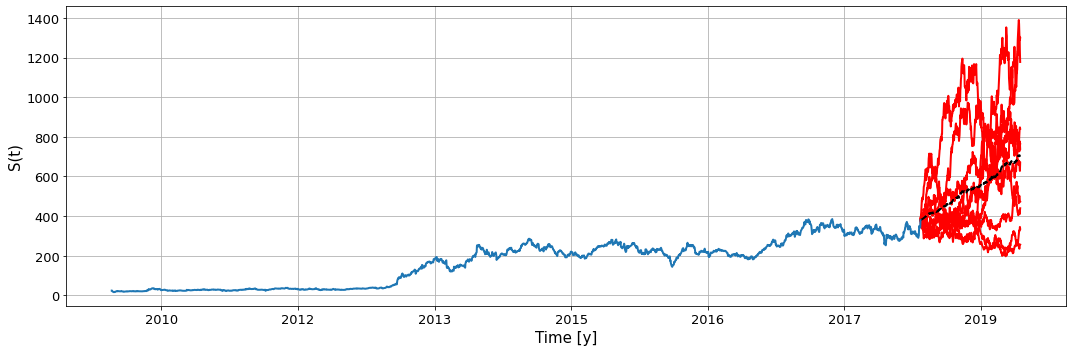

In [5]:
# plot

plt.figure(figsize=(15,5))
plt.plot(t_est + t[-1], S_sim.T, "-r")
plt.plot(t_est + t[-1], np.mean(S_sim, axis=0), "--k", linewidth=2)
plt.plot(t, S.T)
plt.gca().xaxis.set_major_formatter(lambda x, pos: mdates.num2date(x).strftime("%Y"))
plt.xlabel("Time [y]"); plt.ylabel("S(t)"); plt.grid()

---

### Correlated Brownian motion

A a system of SDEs can be written as

\begin{equation}
	d \mathbf{X}
	= \bar{\mathbf{\mu}}dt + \mathbf{D}\mathbf{L} d\tilde{\mathbf{W}}
	= \bar{\mathbf{\mu}}dt + \bar{\mathbf{\sigma}} d\tilde{\mathbf{W}},
\end{equation}

where the matrix $\bar{\mathbf{\sigma}} = \mathbf{D} \cdot \mathbf{L}$ now associates each stochastic process $X_i (t)$ with a random process and defines the linear dependencies (correlations). The matrix $\mathbf{D}$ is the design matrix which maps the interaction of the Brownian motions inbetween the SDEs, whereas lower triangular matrix $\mathbf{L}$ is extracted from the Cholesky decomposition of a correlation matrix $\mathbf{C}$. This allows to express the system of SDEs in terms of a vector of ucorrelated Brownian motions $\tilde{\mathbf{W}}$.

In the [`pyfin.sde` module][pyfin-sde], the [`abm_corr()`] method implements $(3)$, which is showcased by a $2 \times 2$ correlation matrix $\mathbf{C}$ with different values of $\rho_{1,2}$.

[pyfin-sde]: https://github.com/martinandrovich/pyfin/blob/main/pyfin/sde.py
[`abm_corr()`]: https://github.com/martinandrovich/pyfin/blob/main/pyfin/sde.py#L123-L151

In [6]:
from pyfin.sde import abm_corr

# parameters

mu = np.array([0.05, 0.1])
D = np.eye(2, 2)  # mapping of S[] to W[]
rho = 0.7

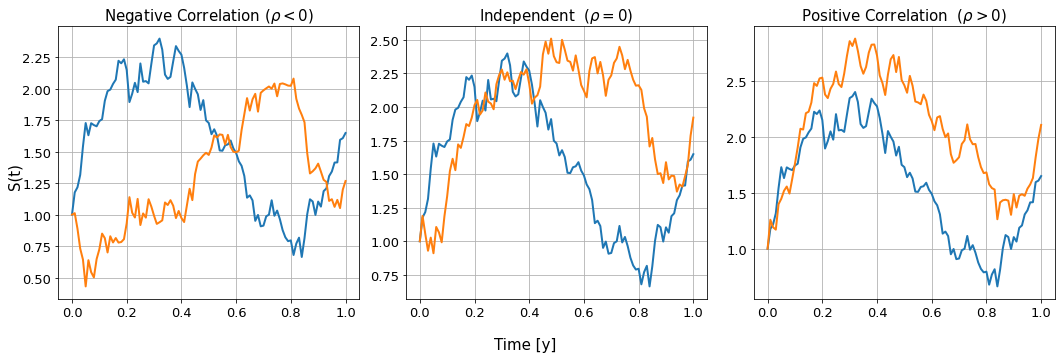

In [7]:

# plot

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

C = np.array([[1, -rho], [-rho, 1]])
t, S = abm_corr(s0=1, mu=mu, D=D, C=C, T=1, reproducible=True)
axs[0].plot(t, S[0])
axs[0].plot(t, S[1])
axs[0].set_title(r"Negative Correlation ($\rho < 0$)")

C = np.array([[1, 0], [0, 1]])
t, S = abm_corr(s0=1, mu=mu, D=D, C=C, T=1, reproducible=True)
axs[1].plot(t, S[0])
axs[1].plot(t, S[1])
axs[1].set_title(r"Independent  ($\rho = 0$)")

C = np.array([[1, rho], [rho, 1]])
t, S = abm_corr(s0=1, mu=mu, D=D, C=C, T=1, reproducible=True)
axs[2].plot(t, S[0])
axs[2].plot(t, S[1])
axs[2].set_title(r"Positive Correlation  ($\rho > 0$)")

for ax in axs.flat:
	ax.ticklabel_format(useOffset=False, style="plain")
	ax.grid()
fig.supylabel("S(t)"); fig.supxlabel("Time [y]");

[pyfin-sde]: https://github.com/martinandrovich/pyfin/blob/main/pyfin/sde.py